# Multi-label Disease Classification of Chest X-Ray Images

UC San Diego Machine Learning Engineering Bootcamp

Tung Nguyen

## Introduction

Dataset: NIH Chest X-Rays from Kaggle, https://www.kaggle.com/nih-chest-xrays/data

This notebook contains trade studies performed with the VGG16 and Xception models

## Imports
---

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from skmultilearn.model_selection.iterative_stratification import iterative_train_test_split

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_Xception
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.metrics import roc_curve, auc, precision_recall_curve, multilabel_confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
random_state = 2022

train_size = 0.8
val_size = 0.2
test_size = 0.25

In [3]:
data_dir = '/Users/tungnguyen/Documents/capstone/data/'

## Data Preprocessing
---

### Wrangling

In [4]:
# Read CSV
df = pd.read_csv('/Users/tungnguyen/Documents/capstone/Data_Entry_2017.csv')

# Drop unnecessary columns
df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis=1, inplace=True)
print('Original DataFrame shape = {}'.format(df.shape))

# Some patients have age >200 - impute with mean of age from rows with the same Patient ID
err = df[df['Patient Age'] > 100]
df_dropped = df[df['Patient Age'] < 100]

for ind, row in err.iterrows():
    pid = row['Patient ID']
    avg = df_dropped[df_dropped['Patient ID'] == pid]['Patient Age'].mean()
    df.iat[ind, 4] = int(avg) if not(np.isnan(avg)) else -1

# There are ~3 patients with just a single datapoint - drop these 3 data points
df = df[df['Patient Age'] != -1]
df.reset_index(inplace=True)
print('Wrangled DataFrame shape = {}'.format(df.shape))

# Replace "No Finding" labels with blank
df['Finding Labels'] = df['Finding Labels'].replace(to_replace='No Finding', value='')

# Binarize
mlb = MultiLabelBinarizer()
lbl = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_mlb = pd.DataFrame(lbl, columns=mlb.classes_, dtype=np.float32)

# Drop 'No Finding' column
df_mlb.drop('', axis=1, inplace=True)

# Merge with main df
df = df.join(df_mlb)
print('Binarized DataFrame shape = {}'.format(df.shape))

# Get list of all labels
labels = [x for x in mlb.classes_ if x != '']
print()
print(labels)

Original DataFrame shape = (112120, 7)
Wrangled DataFrame shape = (112117, 8)
Binarized DataFrame shape = (112117, 22)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


### Splitting

In [5]:
tab_data_cols = ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position']
X = df[tab_data_cols]
y = df[labels]

X_train, y_train, X_test, y_test = iterative_train_test_split(
    X.to_numpy(), 
    y.to_numpy(), 
    test_size=test_size,
)

In [6]:
# Convert matrices to DataFrames for Keras' flow_from_dataframe
train_df = pd.DataFrame(
    np.hstack((X_train, y_train)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

test_df = pd.DataFrame(
    np.hstack((X_test, y_test)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

# Convert labels to float32 for Keras training
for col in train_df:
    if col in labels:
        train_df[col] = train_df[col].astype(np.float32)
        
for col in test_df:
    if col in labels:
        test_df[col] = test_df[col].astype(np.float32)

### Sampling

In [7]:
plt.style.use('tableau-colorblind10')

In [8]:
def plot_df_freq(df, labels, offset=500, title='Frequency of Positive Labels'):
    df_pos = df[labels].sum()

    ax = df_pos.plot(kind='bar', figsize=(15, 7), rot=20);
    ax.set_title(title);
    ax.set_xlabel('Labels');
    ax.set_ylabel('Frequency');

    for i, val in enumerate(df_pos.values):
        ax.text(i, val + offset, int(val), ha = 'center')
        
    return df_pos

In [9]:
weights = []
for i, lbl in enumerate(labels):
    weights.append(dict(enumerate(compute_class_weight(class_weight='balanced', classes=[0., 1.], y=train_df[lbl]))))

# Normalized class weights for weighted loss
pos = np.array([])
neg = np.array([])
for d in weights:
    pos = np.append(pos, d[1] / sum(d.values()))
    neg = np.append(neg, d[0] / sum(d.values())) 
    
# Non-normalized class weights for weighted loss
pos_2 = np.array([])
neg_2 = np.array([])
for d in weights:
    pos_2 = np.append(pos_2, d[1])
    neg_2 = np.append(neg_2, d[0])

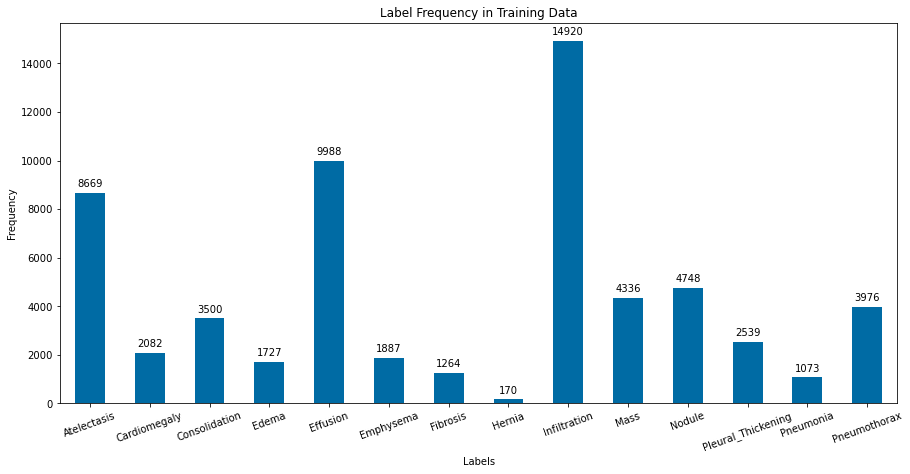

In [10]:
df_freq = plot_df_freq(train_df, labels, offset=250, title='Label Frequency in Training Data')

Atelectasis           5207.0
Cardiomegaly          1673.0
Consolidation         2789.0
Edema                 1525.0
Effusion              6460.0
Emphysema             1593.0
Fibrosis              1121.0
Hernia                 170.0
Infiltration          6902.0
Mass                  3046.0
Nodule                2996.0
Pleural_Thickening    2037.0
Pneumonia             1007.0
Pneumothorax          2773.0
dtype: float32

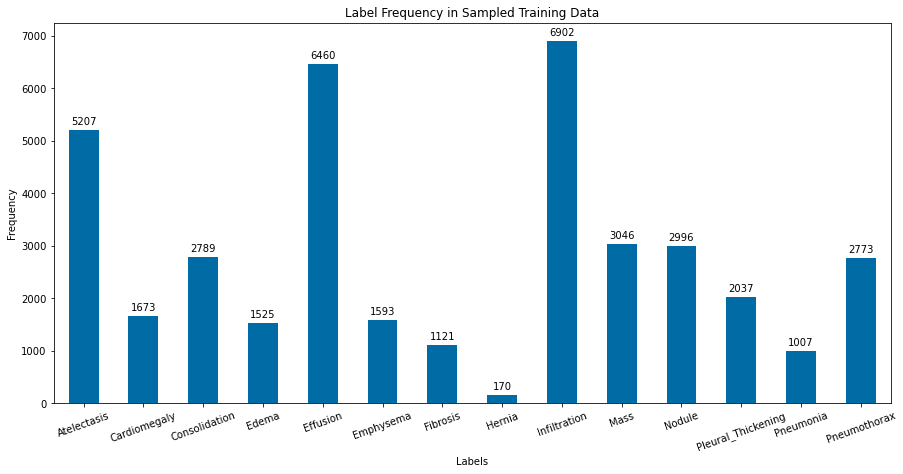

In [11]:
sample_weights = compute_sample_weight(class_weight=weights, y=train_df[labels])
train_df['sample_weights'] = sample_weights

sampled_train_df = train_df.sample(
    20000, 
    weights=sample_weights,
    random_state=random_state
)

plot_df_freq(sampled_train_df, labels, offset=100, title='Label Frequency in Sampled Training Data')

Atelectasis           4586.0
Cardiomegaly          2094.0
Consolidation         2805.0
Edema                 2304.0
Effusion              5547.0
Emphysema             2142.0
Fibrosis              1901.0
Hernia                1548.0
Infiltration          6573.0
Mass                  3173.0
Nodule                2923.0
Pleural_Thickening    2558.0
Pneumonia             1995.0
Pneumothorax          2837.0
dtype: float32

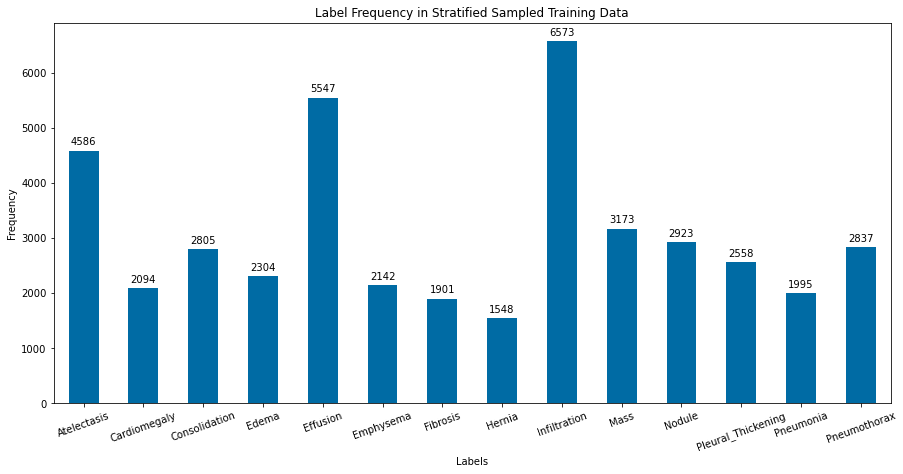

In [12]:
stratified_sampled_train_df = pd.DataFrame([])

n = 1500

# Sample each label
for lbl in labels:
    temp = train_df[train_df[lbl] == 1].sample(
        n,
        replace=True,
        random_state=random_state
    )
    
    stratified_sampled_train_df = pd.concat([stratified_sampled_train_df, temp])
    
# Sample null label
temp = train_df[train_df['Finding Labels'] == ''].sample(
    n,
    replace=False,
    random_state=random_state
)
stratified_sampled_train_df = pd.concat([stratified_sampled_train_df, temp])

plot_df_freq(stratified_sampled_train_df, labels, offset=100, title='Label Frequency in Stratified Sampled Training Data')

In [13]:
def get_weighted_loss(pos, neg, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos)):
            loss += -1 * K.mean(pos * y_true * K.log(y_pred + epsilon) + 
                          (1 - y_true) * neg * K.log(1 - y_pred + epsilon))      
        return loss
    return weighted_loss

### Helper Functions

In [14]:
def plot_losses(model_history, figsize=(15, 10)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(model_history.history['val_loss'], 'r-o')
    ax.plot(model_history.history['loss'], 'b-o')
    ax.set_title('Training vs. Validation Loss')
    ax.legend(['Validation Loss', 'Training Loss'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

def plot_roc_auc(y_pred, test_df, labels, model_name, figsize=(15, 10)):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(fpr, tpr, label = '%s (AUC: %0.2f)'  % (lbl, auc(fpr, tpr)))
        print("AUC = %0.4f for %s" % (auc(fpr, tpr), lbl))

    ax.legend()
    ax.set_title('ROC Curves for Test Data - ' + model_name);
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');

def plot_precision_recall_auc(y_pred, test_df, labels, model_name, figsize=(15, 10)):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(rc, pr, label = '%s (AUC: %0.4f)'  % (lbl, auc(rc, pr)))
        print("AUC = %0.4f for %s" % (auc(rc, pr), lbl))

    ax.legend()
    ax.set_title('Precision-Recall Curves for Test Data - ' + model_name);
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');

In [15]:
def datagen_from_df(train_df, test_df, x_col, y_cols, data_path, preproc_func=None,
                    target_size=(256, 256), val_split=0.2, batch_size=64, sample_size=1000, color_mode='rgb', 
                    sample_center=False, sample_std=False, feature_center=False, feature_std=False, rescale_factor=None, 
                    weight_col=None, random_state=2022):

    datagen = ImageDataGenerator(
        preprocessing_function=preproc_func,
        validation_split=val_split,
        samplewise_center=sample_center,
        samplewise_std_normalization=sample_std,
        featurewise_center=feature_center,
        featurewise_std_normalization=feature_std,
        rescale=rescale_factor,
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range= 0.05, 
        width_shift_range=0.1, 
        rotation_range=5, 
        shear_range = 0.1,
        fill_mode = 'reflect',
        zoom_range=0.15,
    )

    if feature_center or feature_std:
        raw_train_generator = ImageDataGenerator().flow_from_dataframe(
            train_df,   
            data_path,
            shuffle=True,
            batch_size=sample_size,
            class_mode='raw',
            color_mode=color_mode,
            target_size=target_size,
            x_col=x_col,
            y_col=y_cols,
            seed=random_state
        )

        first_batch = raw_train_generator.next()
        data_sample = first_batch[0]
        datagen.fit(data_sample, augment=False, rounds=1, seed=random_state)

    train_generator = datagen.flow_from_dataframe(
        train_df,   
        data_path,
        shuffle=True,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        weight_col=weight_col,
        subset='training',
        seed=random_state
    )

    validation_generator = datagen.flow_from_dataframe(
        train_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='validation',
        seed=random_state
    )

    test_generator = datagen.flow_from_dataframe(
        test_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        seed=random_state
    )
    
    return train_generator, validation_generator, test_generator

In [50]:
# Base Models
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

base_model_Xc = Xception(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

# Callbacks
early = EarlyStopping(
    monitor="val_loss",
    mode="min", 
    patience=8
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=4, 
    min_lr=0.001
)

## Additional Trade Studies
---

### DataGenerators

In [17]:
train_generator_61, valid_generator_61, test_generator_61 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(224, 224), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [18]:
train_generator_62, valid_generator_62, test_generator_62 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(224, 224), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [19]:
train_generator_63, valid_generator_63, test_generator_63 = datagen_from_df(
    stratified_sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(224, 224), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 18000 validated image filenames.
Found 4500 validated image filenames.
Found 28030 validated image filenames.


In [20]:
train_generator_11, valid_generator_11, test_generator_11 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input_Xception,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [62]:
train_generator_111, valid_generator_111, test_generator_111 = datagen_from_df(
    stratified_sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input_Xception,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 18000 validated image filenames.
Found 4500 validated image filenames.
Found 28030 validated image filenames.


### Model 6.1
Best performing model from Round 1 & Round 2 of tuning, with input_shape equal to VGG16 input_shape (224, 224, 3)

In [21]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
#model.summary()

In [22]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [23]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6-1.h5'

chkpt_61 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [24]:
%%time
history_61 = model.fit(
    train_generator_61, 
    validation_data=valid_generator_61,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_61, early, reduce_lr]
)

2022-02-01 20:57:05.597664: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/40


2022-02-01 20:57:06.118355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.3747

2022-02-01 21:01:47.194024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.53473, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6-1.h5
250/250 [==============================] - 339s 1s/step - loss: 1.3747 - val_loss: 1.5347 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.2291
Epoch 00002: val_loss did not improve from 1.53473
250/250 [==============================] - 337s 1s/step - loss: 1.2291 - val_loss: 1.5422 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.2143
Epoch 00003: val_loss improved from 1.53473 to 1.51695, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6-1.h5
250/250 [==============================] - 338s 1s/step - loss: 1.2143 - val_loss: 1.5169 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.2065
Epoch 00004: val_loss did not improve from 1.51695
250/250 [==============================] - 337s 1s/step - loss: 1.2065 

In [25]:
y_pred_61 = model.predict(test_generator_61, batch_size=64, verbose=True)

2022-02-01 22:44:09.497289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 399s 912ms/step


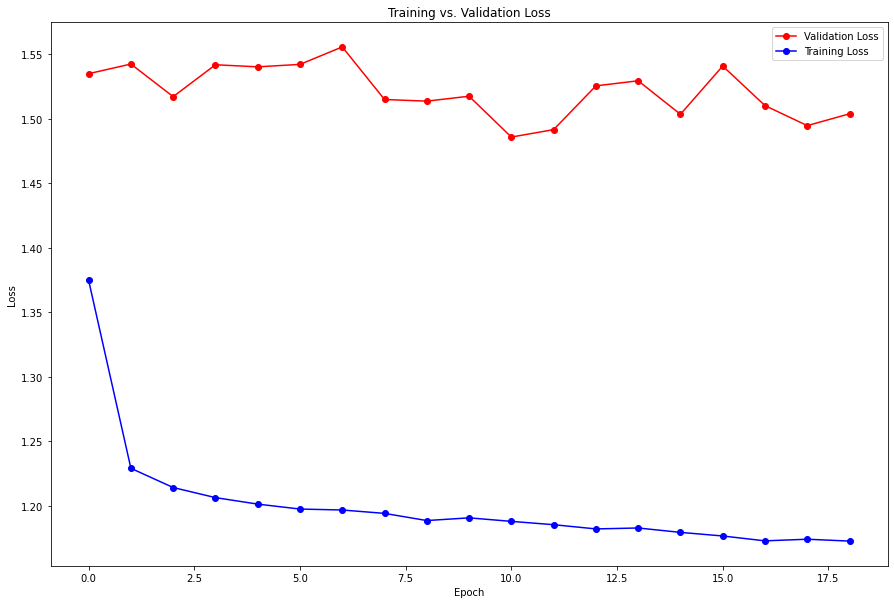

In [26]:
plot_losses(history_61)

AUC = 0.7250 for Atelectasis
AUC = 0.7076 for Cardiomegaly
AUC = 0.7206 for Consolidation
AUC = 0.8168 for Edema
AUC = 0.7760 for Effusion
AUC = 0.5023 for Emphysema
AUC = 0.6080 for Fibrosis
AUC = 0.6342 for Hernia
AUC = 0.6379 for Infiltration
AUC = 0.5287 for Mass
AUC = 0.5462 for Nodule
AUC = 0.5507 for Pleural_Thickening
AUC = 0.4553 for Pneumonia
AUC = 0.5864 for Pneumothorax


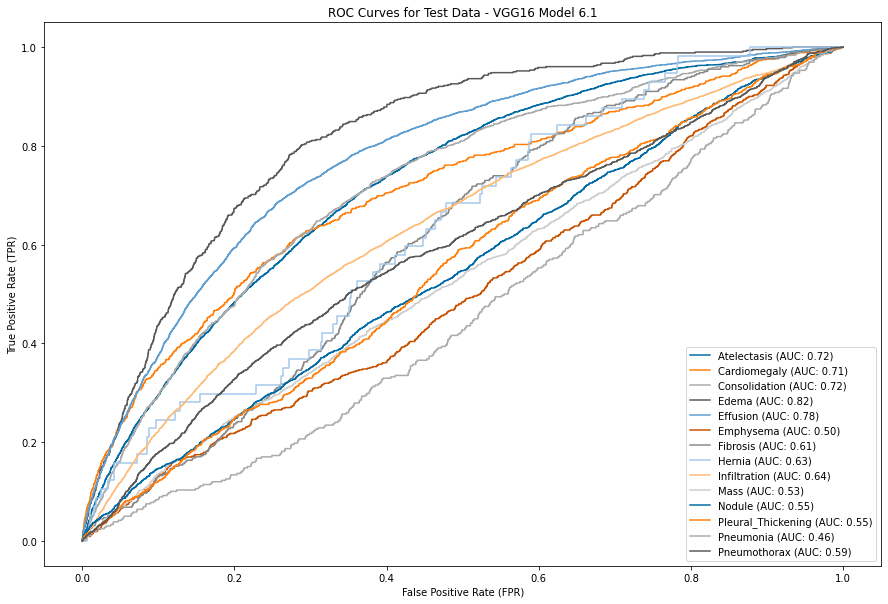

In [27]:
plot_roc_auc(y_pred_61, test_df, labels, model_name='VGG16 Model 6.1')

### Model 6.2
Same as Model 6.1, except with GlobalAveragePooling instead of a simple Flatten

In [28]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True
    
model.add(GlobalAveragePooling2D())
model.add(Dense(len(labels), activation='sigmoid'))
    
#model.summary()

In [29]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [30]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6-2.h5'

chkpt_62 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [31]:
%%time
history_62 = model.fit(
    train_generator_62, 
    validation_data=valid_generator_62,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_62, early, reduce_lr]
)

Epoch 1/40


2022-02-01 22:50:50.942405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.2238

2022-02-01 22:55:31.684664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.51566, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6-2.h5
250/250 [==============================] - 339s 1s/step - loss: 1.2238 - val_loss: 1.5157 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.1977
Epoch 00002: val_loss improved from 1.51566 to 1.47300, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6-2.h5
250/250 [==============================] - 337s 1s/step - loss: 1.1977 - val_loss: 1.4730 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.1887
Epoch 00003: val_loss did not improve from 1.47300
250/250 [==============================] - 337s 1s/step - loss: 1.1887 - val_loss: 1.5064 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.1777
Epoch 00004: val_loss did not improve from 1.47300
250/250 [==============================] - 337s 1s/step - loss: 1.1777 

In [32]:
y_pred_62 = model.predict(test_generator_62, batch_size=64, verbose=True)

2022-02-02 00:38:09.357710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 401s 916ms/step


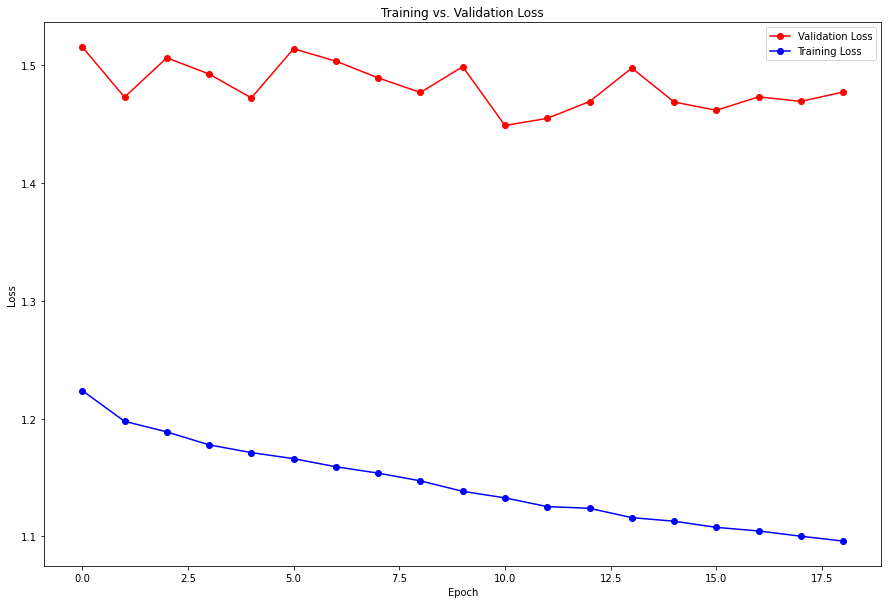

In [33]:
plot_losses(history_62)

AUC = 0.7434 for Atelectasis
AUC = 0.8608 for Cardiomegaly
AUC = 0.7303 for Consolidation
AUC = 0.8524 for Edema
AUC = 0.8221 for Effusion
AUC = 0.6532 for Emphysema
AUC = 0.6565 for Fibrosis
AUC = 0.7882 for Hernia
AUC = 0.6496 for Infiltration
AUC = 0.6700 for Mass
AUC = 0.5699 for Nodule
AUC = 0.6488 for Pleural_Thickening
AUC = 0.5333 for Pneumonia
AUC = 0.7178 for Pneumothorax


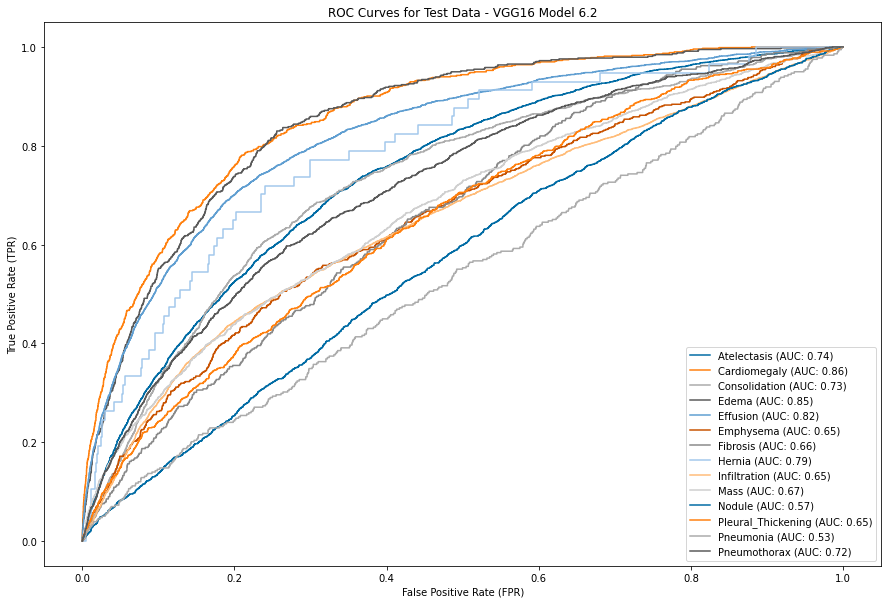

In [34]:
plot_roc_auc(y_pred_62, test_df, labels, model_name='VGG16 Model 6.2')

### Model 6.3
Model 6.1 with stratified sampled dataframe and modified initial learning rate

In [35]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
#model.summary()

In [36]:
model.compile(
    optimizer=Adam(learning_rate=0.05),
    loss=get_weighted_loss(pos, neg)
)

In [37]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6-3.h5'

chkpt_63 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [38]:
%%time
history_63 = model.fit(
    train_generator_63, 
    validation_data=valid_generator_63,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_63, early, reduce_lr]
)

Epoch 1/40


2022-02-02 00:44:52.496650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - ETA: 0s - loss: 15.6939

2022-02-02 00:50:08.134578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 26.13039, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6-3.h5
282/282 [==============================] - 380s 1s/step - loss: 15.6939 - val_loss: 26.1304 - lr: 0.0500
Epoch 2/40
282/282 [==============================] - ETA: 0s - loss: 15.8146
Epoch 00002: val_loss improved from 26.13039 to 26.12197, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6-3.h5
282/282 [==============================] - 380s 1s/step - loss: 15.8146 - val_loss: 26.1220 - lr: 0.0500
Epoch 3/40
282/282 [==============================] - ETA: 0s - loss: 15.8096
Epoch 00003: val_loss improved from 26.12197 to 26.09021, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round2/vgg16-model-6-3.h5
282/282 [==============================] - 380s 1s/step - loss: 15.8096 - val_loss: 26.0902 - lr: 0.0500
Epoch 4/40
282/282 [==============================] - ETA: 0s - loss: 15.8326
Epoch 00004: v

In [39]:
y_pred_63 = model.predict(test_generator_63, batch_size=64, verbose=True)

2022-02-02 01:55:09.916772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 401s 916ms/step


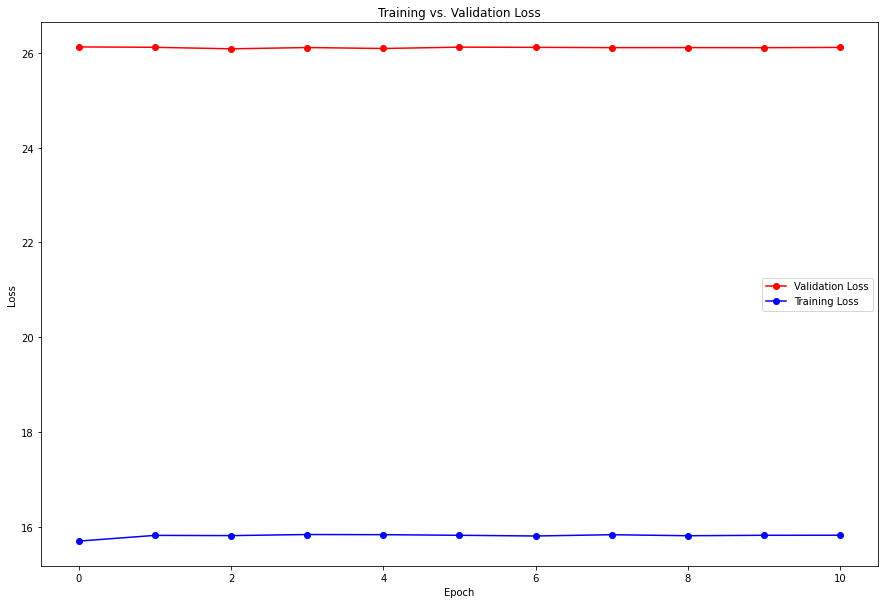

In [40]:
plot_losses(history_63)

AUC = 0.5000 for Atelectasis
AUC = 0.5000 for Cardiomegaly
AUC = 0.5000 for Consolidation
AUC = 0.5000 for Edema
AUC = 0.4996 for Effusion
AUC = 0.5032 for Emphysema
AUC = 0.5000 for Fibrosis
AUC = 0.5000 for Hernia
AUC = 0.5000 for Infiltration
AUC = 0.5000 for Mass
AUC = 0.5000 for Nodule
AUC = 0.5000 for Pleural_Thickening
AUC = 0.5000 for Pneumonia
AUC = 0.5000 for Pneumothorax


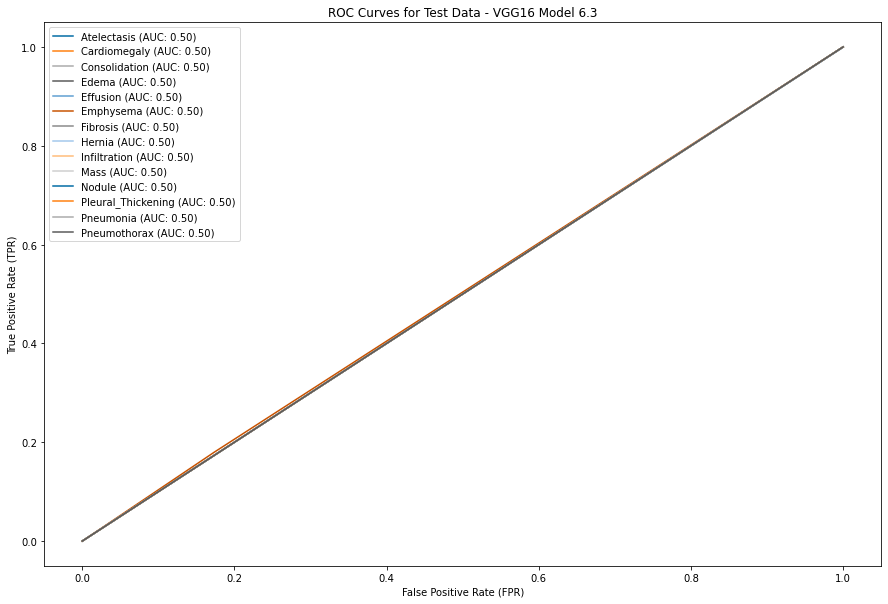

In [41]:
plot_roc_auc(y_pred_63, test_df, labels, model_name='VGG16 Model 6.3')

### Model 11: Xception
This model uses the Xception pre-trained model instead of VGG16. However, the model is still trained on a subset of the data.

In [53]:
output_layer = Dense(len(labels), activation='sigmoid')(base_model_Xc.output)
model_Xc = Model(base_model_Xc.input, output_layer)

for layer in model_Xc.layers:
    layer.trainable = True
    
#model_Xc.summary()

In [54]:
model_Xc.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [55]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round3/Xception-model-11.h5'

chkpt_11 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [57]:
%%time
history_11 = model_Xc.fit(
    train_generator_11, 
    validation_data=valid_generator_11,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_11, early, reduce_lr]
)

Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 1.0560
Epoch 00001: val_loss improved from 1.84166 to 1.47794, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round3/Xception-model-11.h5
250/250 [==============================] - 374s 1s/step - loss: 1.0560 - val_loss: 1.4779 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.0228
Epoch 00002: val_loss did not improve from 1.47794
250/250 [==============================] - 373s 1s/step - loss: 1.0228 - val_loss: 1.6513 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.0016
Epoch 00003: val_loss did not improve from 1.47794
250/250 [==============================] - 373s 1s/step - loss: 1.0016 - val_loss: 1.6462 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 0.9785
Epoch 00004: val_loss did not improve from 1.47794
250/250 [==============================] - 373s 1s/step - loss: 0.9785 - val_loss: 

In [59]:
y_pred_11 = model_Xc.predict(test_generator_11, batch_size=64, verbose=True)

2022-02-02 08:15:56.450361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 464s 1s/step


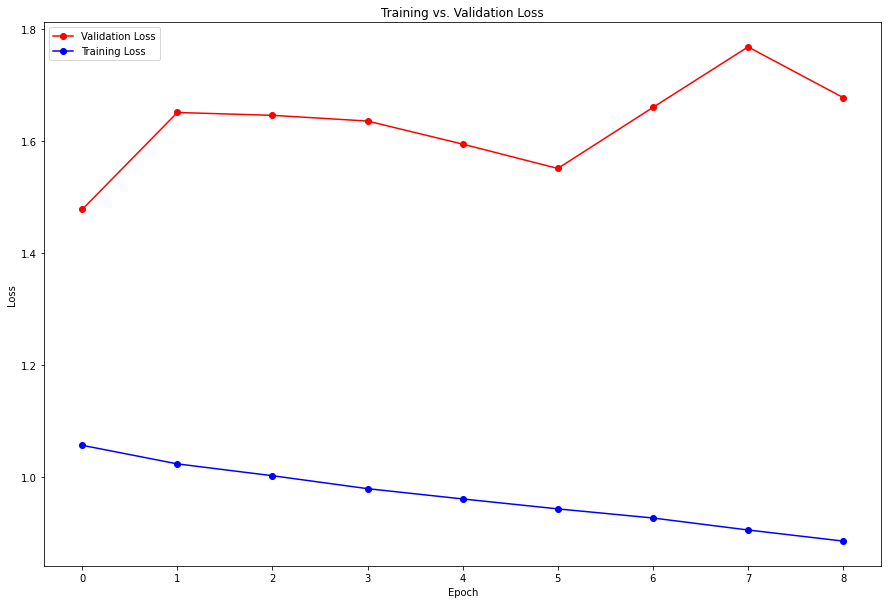

In [60]:
plot_losses(history_11)

AUC = 0.7763 for Atelectasis
AUC = 0.8633 for Cardiomegaly
AUC = 0.7262 for Consolidation
AUC = 0.8828 for Edema
AUC = 0.8401 for Effusion
AUC = 0.8513 for Emphysema
AUC = 0.7558 for Fibrosis
AUC = 0.7804 for Hernia
AUC = 0.6357 for Infiltration
AUC = 0.7751 for Mass
AUC = 0.7089 for Nodule
AUC = 0.7282 for Pleural_Thickening
AUC = 0.5659 for Pneumonia
AUC = 0.8250 for Pneumothorax


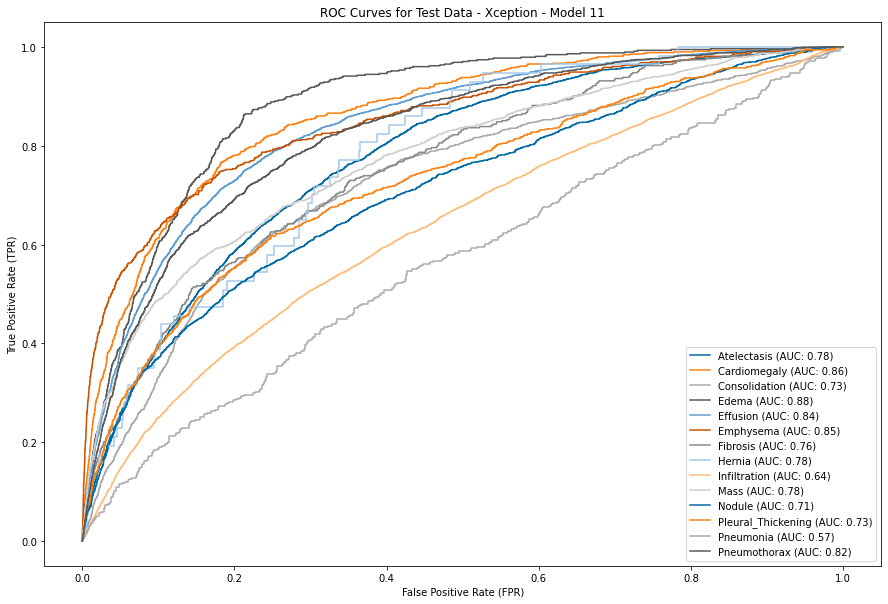

In [61]:
plot_roc_auc(y_pred_11, test_df, labels, model_name='Xception - Model 11')

### Model 11.1: Xception (Stratified)
This model uses the Xception pre-trained model instead of VGG16. However, the model is still trained on a subset of the stratified data.

In [63]:
base_model_Xc_2 = Xception(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

output_layer = Dense(len(labels), activation='sigmoid')(base_model_Xc_2.output)
model_Xc_2 = Model(base_model_Xc_2.input, output_layer)

for layer in model_Xc_2.layers:
    layer.trainable = True
    
#model_Xc.summary()

In [64]:
model_Xc_2.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [65]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Round3/Xception-model-11-1.h5'

chkpt_111 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [66]:
%%time
history_111 = model_Xc_2.fit(
    train_generator_111, 
    validation_data=valid_generator_111,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_111, early, reduce_lr]
)

Epoch 1/40


2022-02-02 08:36:02.634371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - ETA: 0s - loss: 1.1131

2022-02-02 08:41:52.220920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.40263, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Round3/Xception-model-11-1.h5
282/282 [==============================] - 425s 1s/step - loss: 1.1131 - val_loss: 1.4026 - lr: 0.0010
Epoch 2/40
282/282 [==============================] - ETA: 0s - loss: 1.0295
Epoch 00002: val_loss did not improve from 1.40263
282/282 [==============================] - 420s 1s/step - loss: 1.0295 - val_loss: 1.5022 - lr: 0.0010
Epoch 3/40
282/282 [==============================] - ETA: 0s - loss: 0.9785
Epoch 00003: val_loss did not improve from 1.40263
282/282 [==============================] - 420s 1s/step - loss: 0.9785 - val_loss: 1.7580 - lr: 0.0010
Epoch 4/40
282/282 [==============================] - ETA: 0s - loss: 0.9349
Epoch 00004: val_loss did not improve from 1.40263
282/282 [==============================] - 422s 1s/step - loss: 0.9349 - val_loss: 1.7361 - lr: 0.0010
Epoch 5/40
282/282 [==============================] - ETA:

In [ ]:
y_pred_111 = model_Xc_2.predict(test_generator_111, batch_size=64, verbose=True)

2022-02-02 08:15:56.450361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 464s 1s/step


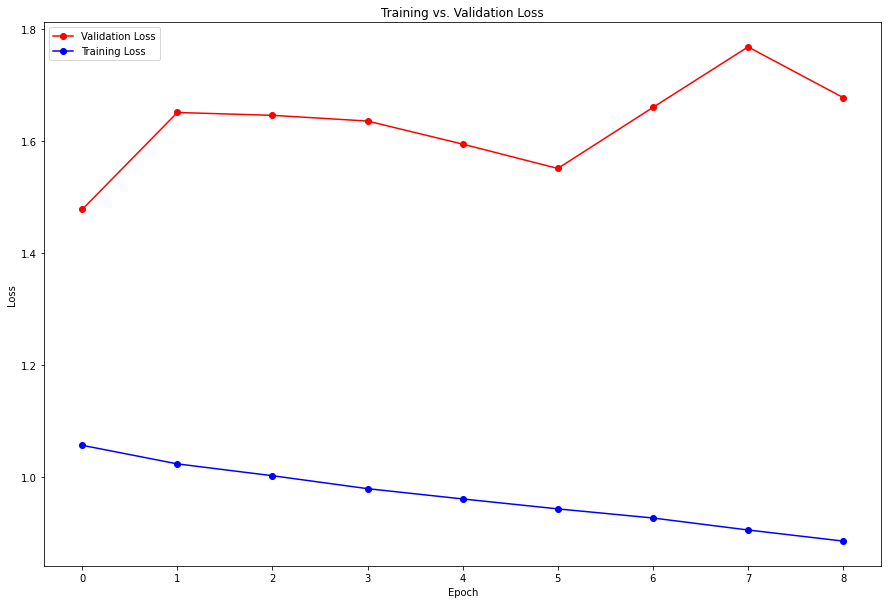

In [ ]:
plot_losses(history_111)

AUC = 0.7763 for Atelectasis
AUC = 0.8633 for Cardiomegaly
AUC = 0.7262 for Consolidation
AUC = 0.8828 for Edema
AUC = 0.8401 for Effusion
AUC = 0.8513 for Emphysema
AUC = 0.7558 for Fibrosis
AUC = 0.7804 for Hernia
AUC = 0.6357 for Infiltration
AUC = 0.7751 for Mass
AUC = 0.7089 for Nodule
AUC = 0.7282 for Pleural_Thickening
AUC = 0.5659 for Pneumonia
AUC = 0.8250 for Pneumothorax


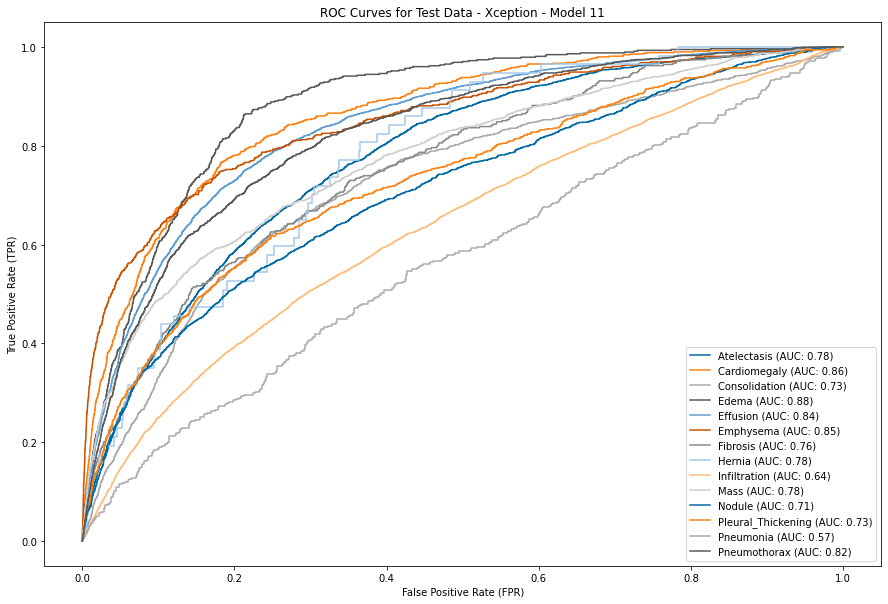

In [ ]:
plot_roc_auc(y_pred_111, test_df, labels, model_name='Xception - Model 11.1')

## Store Variables
---